In [1]:
import numpy as np
import xarray as xr
from scipy.stats import linregress as _linregress
import matplotlib.pyplot as plt

In [ ]:
# 850 datasets 
# ERA5
era5 = xr.open_dataset('/scratch/midway3/krucker01/ERA5/tmp_pl_1980-2024_regrid.nc')
era5 = era5.compute()
era5_850 = era5.sel(level=850)

# AMIP
amip_850 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/AMIP/ta850_CMIP6_Amon_amip_1979-2014_allmembers.nc')
amip_850 = amip_850.rename({'lat': 'latitude','lon': 'longitude'})
amip_850 = amip_850.compute()
amip_850['latitude'] = era5['latitude']
amip_850['longitude'] = era5['longitude']
cesm = amip_850.sel(member_id = ['CESM2-FV2_r1i1p1f1','CESM2-WACCM-FV2_r1i1p1f1', 'CESM2-WACCM_r1i1p1f1','CESM2-WACCM_r2i1p1f1', 'CESM2-WACCM_r3i1p1f1', 'CESM2_r1i1p1f1'])

# ACE2
ace2 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_t850_1980_2022_128x64.nc')
ace2['latitude'] = era5['latitude']
ace2['longitude'] = era5['longitude']
ace2 = ace2.squeeze().compute()

# NGCM
ngcm = xr.open_dataset("/scratch/midway3/krucker01/ai-models/ngcm/climate_2.8_csp_pe/tmp_monthly_1981-2023_csp_pe.nc")
ngcm['latitude'] = era5['latitude']
ngcm['longitude'] = era5['longitude']
ngcm = ngcm.compute()
ngcm_850 = ngcm.sel(level = 850)

In [7]:
# Functions 

def linregress(da_y, da_x, dim=None):
    '''xarray-wrapped function of scipy.stats.linregress.
    Note the order of the input arguments x, y is reversed to the original scipy function.'''
    if dim is None:
        dim = [d for d in da_y.dims if d in da_x.dims][0]
    slope, intercept, r, p, stderr = xr.apply_ufunc(_linregress, da_x, da_y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True,
        dask='allowed')
    predicted = da_x * slope + intercept
    slope.attrs['long_name'] = 'slope of the linear regression'
    intercept.attrs['long_name'] = 'intercept of the linear regression'
    r.attrs['long_name'] = 'correlation coefficient'
    p.attrs['long_name'] = 'p-value'
    stderr.attrs['long_name'] = 'standard error of the estimated gradient'
    predicted.attrs['long_name'] = 'predicted values by the linear regression model'
    return xr.Dataset(dict(slope=slope, intercept=intercept,
        r=r, p=p, stderr=stderr, predicted=predicted))

def area_weighted_ave(ds):
    if 'lat' not in ds.dims:
        ds = ds.rename({'latitude':'lat','longitude':'lon'})
    coslat = np.cos(np.deg2rad(ds.lat))
    ds,coslat = xr.broadcast(ds,coslat)
    ds = ds * coslat
    #return ds.mean(('lat','lon'),skipna=True)
    return ds.sum(('lat','lon'),skipna=True)/((ds/ds)*coslat).sum(('lat','lon'),skipna=True)

In [8]:
# Geopotential Mask
mask_array = xr.open_dataset('/scratch/midway3/itbaxter/NeuralGCM_Decadal_Simulations/geopot_mask.nc')
mask = mask_array.__xarray_dataarray_variable__
mask = xr.where(mask, 1, np.nan)

In [10]:
# Define latitude bins 
lats = np.array([-90,-60,-20,20,60,90])

In [ ]:
era5_trends = np.zeros(int(len(lats)-1))

for t in range(len(lats)-1):
    era5_slice = era5_850.sel(latitude = slice(lats[t],lats[t+1]))
    era5_lonavg_oro = area_weighted_ave(((era5_slice*mask.sel(level=850)).groupby('time.year').mean('time')).sel(year = slice(1981,2014)))
    era5_trend = (((linregress(era5_lonavg_oro['t'],era5_lonavg_oro['year']).slope)*10))#.mean('latitude')

    era5_trends[t] = era5_trend
    print(str(lats[t])+'-'+str(lats[t+1]))

-90--60
-60--20
-20-20
20-60
60-90


In [ ]:
amip_trends = np.zeros((len(amip_850['member_id']),int(len(lats)-1)))
amip_trends_ens = np.zeros(int(len(lats)-1))


for t in range(len(lats)-1):
    amip_850_lonavg_oro = area_weighted_ave(((amip_850.sel(latitude = slice(lats[t],lats[t+1]))*mask.sel(level=850)).groupby('time.year').mean('time')).sel(year = slice(1981,2014)))
    amip_850_trend_oro = (((linregress(amip_850_lonavg_oro['ta'], amip_850_lonavg_oro['year']).slope)*10))#.mean('latitude')
    amip_850_trend_ens_oro = amip_850_trend_oro.mean('member_id')

    amip_trends[:,t] = amip_850_trend_oro
    amip_trends_ens[t] = amip_850_trend_ens_oro
    print(str(lats[t])+'-'+str(lats[t+1]))


amip_05 = np.nanquantile(amip_trends, 0.05, axis = 0)
amip_95 = np.nanquantile(amip_trends, 0.95 ,axis = 0)

-90--60
-60--20
-20-20
20-60
60-90


In [ ]:
cesm_trends = np.zeros((len(cesm['member_id']),int(len(lats)-1)))
cesm_trends_ens = np.zeros(int(len(lats)-1))


for t in range(len(lats)-1):
    cesm_lonavg_oro = area_weighted_ave(((cesm.sel(latitude = slice(lats[t],lats[t+1]))*mask.sel(level=850)).groupby('time.year').mean('time')).sel(year = slice(1981,2014)))  
    cesm_trend_oro = (((linregress(cesm_lonavg_oro['ta'], cesm_lonavg_oro['year']).slope)*10))#.mean('latitude')
    cesm_trend_ens_oro = cesm_trend_oro.mean('member_id')

    cesm_trends[:,t] = cesm_trend_oro
    cesm_trends_ens[t] = cesm_trend_ens_oro
    print(str(lats[t])+'-'+str(lats[t+1]))

cesm_05 = np.nanquantile(cesm_trends, 0.05, axis = 0)
cesm_95 = np.nanquantile(cesm_trends, 0.95 ,axis = 0)

-90--60
-60--20
-20-20
20-60
60-90


In [ ]:
ace2_trends = np.zeros((len(ace2['member_id']),int(len(lats)-1)))
ace2_trends_ens = np.zeros(int(len(lats)-1))

for t in range(len(lats)-1):
    ace2_850_lonavg_oro = area_weighted_ave(((ace2.sel(latitude = slice(lats[t],lats[t+1]))*mask.sel(level=850)).groupby('time.year').mean('time')).sel(year = slice(1981,2014)))   
    ace2_850_trend_oro = ((linregress(ace2_850_lonavg_oro.to_dataarray(), ace2_850_lonavg_oro['year']).slope)*10)#.mean('latitude')
    ace2_850_trend_ens_oro = ace2_850_trend_oro.mean('member_id')

    ace2_trends[:,t] = ace2_850_trend_oro[0,:]
    ace2_trends_ens[t] = ace2_850_trend_ens_oro
    print(str(lats[t])+'-'+str(lats[t+1]))

ace2_05 = np.nanquantile(ace2_trends, 0.05, axis = 0)
ace2_95 = np.nanquantile(ace2_trends, 0.95 ,axis = 0)

-90--60
-60--20
-20-20
20-60
60-90


In [ ]:
ngcm_trends = np.zeros((len(ngcm_850),int(len(lats)-1)))
ngcm_trends_ens = np.zeros(int(len(lats)-1))

for t in range(len(lats)-1):
    ngcm_850_lonavg_oro = area_weighted_ave(((ngcm_850.sel(latitude = slice(lats[t],lats[t+1]))*mask.sel(level=850)).groupby('time.year').mean('time')).sel(year = slice(1981,2014)))  
    ngcm_850_trend_oro = ((linregress(ngcm_850_lonavg_oro.to_dataarray(), ngcm_850_lonavg_oro['year']).slope)*10)#.mean('latitude')
    ngcm_850_trend_ens_oro = ngcm_850_trend_oro.mean('variable')

    # amip_trends[str(lats[t])+'-'+str(lats[t+1])] = amip_850_trend_oro
    # amip_trends_ens[str(lats[t])+'-'+str(lats[t+1])] = amip_850_trend_ens_oro
    ngcm_trends[:,t] = ngcm_850_trend_oro
    ngcm_trends_ens[t] = ngcm_850_trend_ens_oro
    print(str(lats[t])+'-'+str(lats[t+1]))

ngcm_05 = np.nanquantile(ngcm_trends, 0.05, axis = 0)
ngcm_95 = np.nanquantile(ngcm_trends, 0.95 ,axis = 0)

-90--60
-60--20
-20-20
20-60
60-90


In [ ]:
# Time series 
lat_min = -20
lat_max = 20

era5_lat = era5_850.sel(latitude = slice(lat_min,lat_max))
era5_time = area_weighted_ave(era5_lat).groupby('time.year').mean('time')
era5_norm = era5_time - (era5_time.sel(year=slice(1980,1990)).mean().t)

In [17]:
amip_1 = amip_850.mean('member_id').sel(latitude = slice(lat_min,lat_max))
amip_time = area_weighted_ave(amip_1).groupby('time.year').mean('time').mean('bnds')
amip_norm = amip_time-(amip_time.sel(year=slice(1980,1990)).mean().ta)

In [18]:
ace2_time = area_weighted_ave(ace2.mean('member_id').sel(latitude = slice(lat_min,lat_max))).groupby('time.year').mean('time').sel(year=slice(1979,2021))
ace2_norm = ace2_time-(ace2_time.sel(year=slice(1980,1990)).mean().TMP850)

In [19]:
ngcm_time = area_weighted_ave(ngcm_850.to_dataarray().mean('variable').sel(latitude = slice(lat_min,lat_max))).groupby('time.year').mean('time')
ngcm_norm = ngcm_time-(ngcm_time.sel(year=slice(1980,1990)).mean())

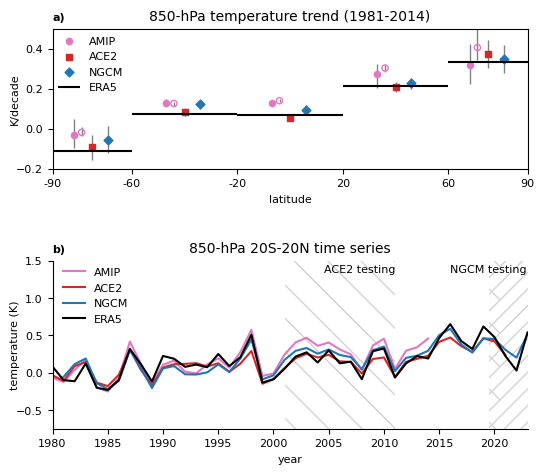

In [ ]:
fig, ax = plt.subplots(figsize = (4.75,4))
plt.axis('off')
plt.rcParams['hatch.color'] = 'lightgray' 

font = 8
plt.rc('font', size=font)
size = 20
linewidth = 1
x = np.array([-75,-40,0,40,75])
fig.text(0,1.02, 'a)', weight = 'bold', fontsize = font)
fig.text(0,0.44, 'b)', weight = 'bold', fontsize = font)
ax = fig.add_axes([0,0.65,1,0.35])

plt.vlines(x-7, ymin = amip_05, ymax = amip_95, zorder = -1, color = 'grey', linewidth = linewidth)
amip_plot = ax.scatter(x-7,amip_trends.mean(axis=0), marker = 'o', color = '#E377C2', zorder = 1, s = size)

plt.vlines(x, ymin = ace2_05, ymax = ace2_95, zorder = -1, color = 'grey', linewidth = linewidth)
ace2_plot = ax.scatter(x,ace2_trends.mean(axis=0), marker = 's', color = '#D62728', zorder = 1, s = size)

plt.vlines(x+6, ymin = ngcm_05, ymax = ngcm_95, zorder = -1, color = 'grey', linewidth = linewidth)
ngcm_plot = ax.scatter(x+6, ngcm_trends.mean(axis=0), marker = 'D', color = '#1F77B4', zorder = 1, s = size)

for i in range(len(era5_trends)):
    era5_plot = plt.hlines(era5_trends[i], lats[i], lats[i+1], 'k')

plt.vlines(x-4, ymin = cesm_05, ymax = cesm_95, zorder = -1, color = 'grey', linewidth = linewidth)
cesm_plot = ax.scatter(x-4,cesm_trends.mean(axis=0), marker = 'o', edgecolors= '#E377C2', facecolor = 'none', zorder = 1, s = size)


ax.set_xlim(-90,90)
ax.set_ylim(-0.2, 0.5)
ax.set_yticks([-0.2,0,0.2,0.4])
ax.set_ylabel("K/decade", fontsize = font, labelpad= -3)
ax.set_xlabel("latitude", fontsize = font)
ax.set_title("850-hPa temperature trend (1981-2014)", fontsize = font+2)
ax.set_xticks(np.array([-90,-60,-20,20,60,90]))
ax.set_xticklabels(['-90','-60','-20','20','60','90'])
ax.tick_params(axis = 'both', labelsize = font)
plt.legend([amip_plot, ace2_plot, ngcm_plot, era5_plot], ['AMIP', 'ACE2', 'NGCM', 'ERA5'], loc = 'upper left', fontsize = font, frameon=False, bbox_to_anchor = (-0.01,1.02))

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

ax = fig.add_axes([0,0,1,0.42])

ax.plot(amip_norm.year, amip_norm.ta, color = '#E377C2', label = 'AMIP')
ax.plot(ace2_norm.year, ace2_norm.TMP850, color = '#D62728', label = 'ACE2')
ax.plot(ngcm_norm.year, ngcm_norm, color = '#1F77B4', label = 'NGCM')
ax.plot(era5_norm.year[:-1], era5_norm.t[:-1], color = 'k', label = 'ERA5')
plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.set_xlim([1980,2023])
ax.set_ylim([-0.75,1.5])
ax.set_title(f'850-hPa 20S-20N time series', fontsize = font+2)
ax.set_ylabel("temperature (K)", fontsize = font, labelpad= -3)
ax.set_xlabel("year", fontsize = font)
ax.tick_params(axis = 'both', labelsize = font)
ax.legend(frameon=False, bbox_to_anchor = (0,1.02), loc = 'upper left')
ax.text(2011,1.45, 'ACE2 testing', ha = 'right', va = 'top', fontsize = font)
ax.text(2022.9,1.45, 'NGCM testing', ha = 'right', va = 'top', fontsize = font)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.savefig('Thermo Fig 1.eps', dpi = 600, bbox_inches='tight');